In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns

In [59]:
id2label = {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}
label2id = {'CONTRADICTION': 0, 'NEUTRAL':1, 'ENTAILMENT':2}
tasks = ['adjr', 'comp', 'ncon', 'subjv', 'temp', 'verb']
map_name = {'adjr' : 'Adjective-Reference binding', 'comp': 'Comparisons', 
            'temp': 'Temporal ordering', 'subjv': 'Subject-Verb binding',
           'ncon': 'Negating a Condition', 'verb': 'Verb Symmetry'}

def loadresults(name, classifier, tasks, outpaths):
    modelname = name + classifier
    results = {}
    print('\n\n'+'**'*40)
    print("\nLoading tests for {0}...\n".format(modelname))
    print('**'*40 + '\n')
    for task in tasks:
        results[task] = {}
        results[task]['est'] = np.loadtxt('{0}{1}_labels_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname), dtype = int)
        results[task]['est_conf'] = np.loadtxt('{0}{1}_confs_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname))
        results[task]['true'] = np.loadtxt('{0}labels.{1}'.format(outpaths['TEST_DATA_PATH'], task), dtype = int)
        
        results[task]['est'] = np.array([id2label[x] for x in results[task]['est']])
        results[task]['true'] = np.array([id2label[x] for x in results[task]['true']])
    return results


In [52]:
toy = True 
TEST_OUT_PATH = './regout/'
outpaths = {}
if toy:
    outpaths['TEST_OUT_PATH'] = './regout/TOY'
    outpaths['TEST_DATA_PATH'] = './testData/toy/'
else:
    outpaths['TEST_OUT_PATH'] = './regout/'
    outpaths['TEST_DATA_PATH'] = './testData/true/'



names = ['InferSent', 'BOW']
classifiers = [ 'LogReg', 'MLP']
all_results = {}
for name in names:
    for classifier in classifiers:
        all_results[name+classifier] = loadresults(name, classifier, tasks, outpaths)




********************************************************************************

Loading tests for InferSentLogReg...

********************************************************************************



********************************************************************************

Loading tests for InferSentMLP...

********************************************************************************



********************************************************************************

Loading tests for BOWLogReg...

********************************************************************************



********************************************************************************

Loading tests for BOWMLP...

********************************************************************************



In [53]:
def plot_hist(data):
    # Create the bar plot
    ax = sns.countplot(
        x="est",
        hue="true",
        order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        hue_order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        data=data)
    return plt.gcf(), ax

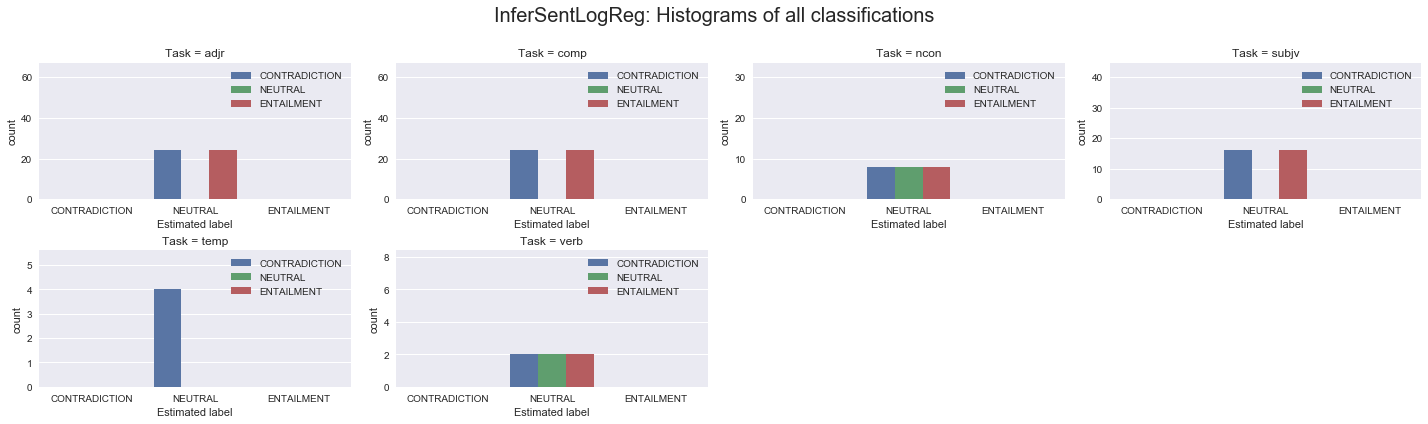

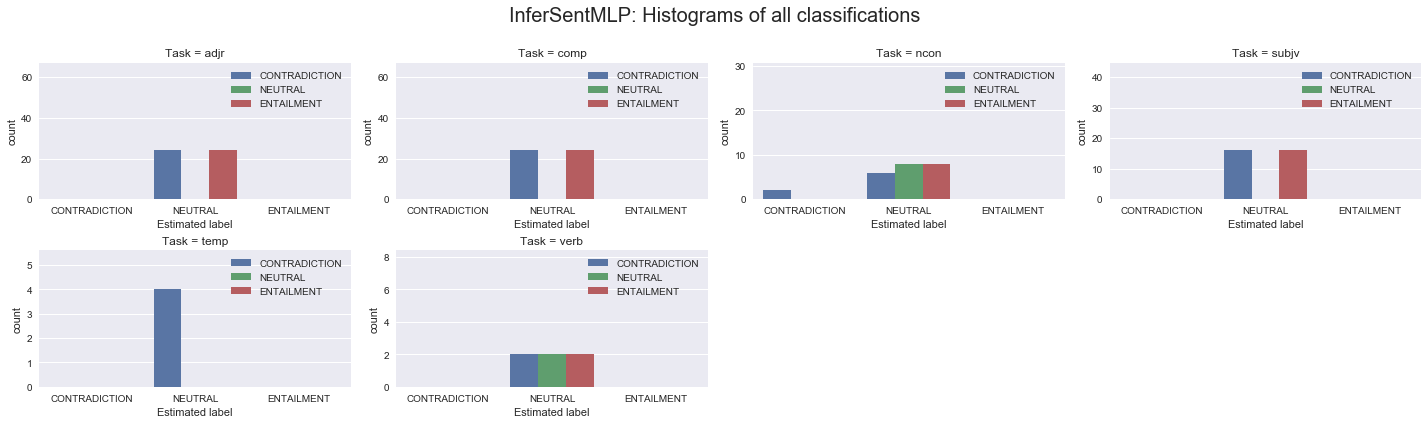

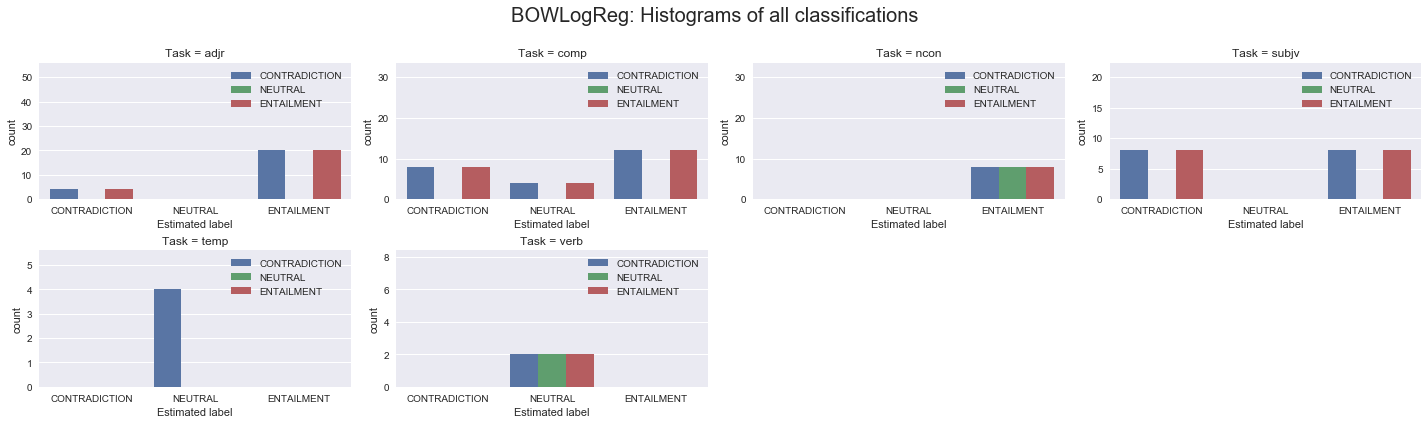

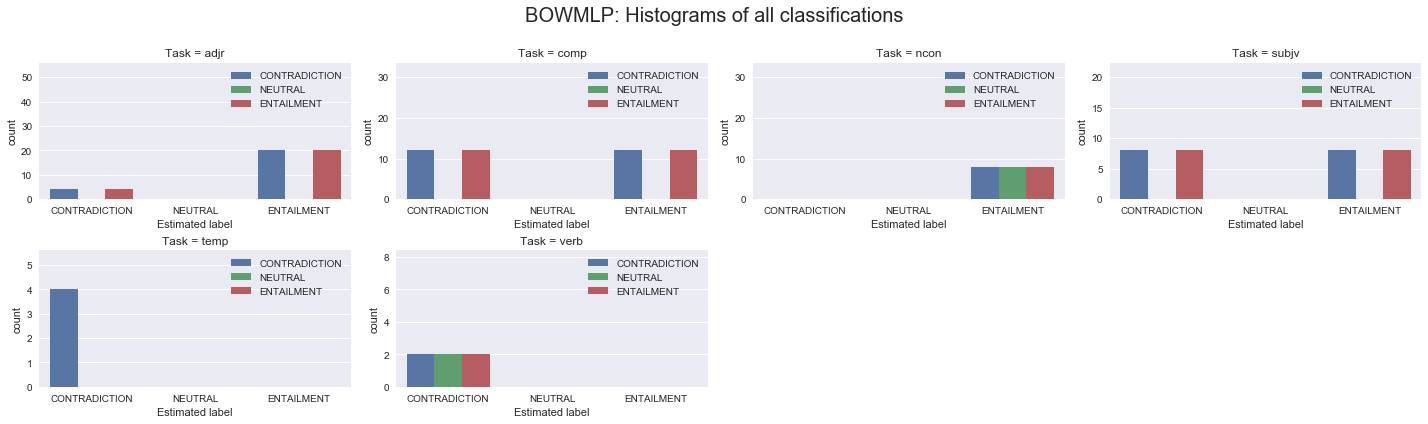

In [54]:
for model in all_results:
    plt.figure(figsize=(20, 6))
    for i, task in enumerate(all_results[model]):
        plt.subplot(2,4,i+1)
        a, b = plot_hist(all_results[model][task])
#         lim = max(np.concatenate((np.bincount(all_results[model][task]['est']), np.bincount(all_results[model][task]['true']))))*1.4
#         plt.ylim([0,lim])
        plt.legend(loc='upper right')
        b.set_title('Task = {0}'.format(task))
        lim = max(np.concatenate((np.bincount([label2id[x.strip()] for x in all_results[model][task]['est']]), 
                                  np.bincount([label2id[x.strip()] for x in all_results[model][task]['true']])
                                 )))*1.4
        b.set_ylim([0,lim])
        b.set_xlabel("Estimated label")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle('{0}: Histograms of all classifications'.format(model), fontsize = 20)
        



In [55]:
N = 1
plt.figure(figsize=(20, 10))
n_task = 0

for task in tasks:
    n_task +=1 
    print('\nTASK: ', task, "\n\n")
    with open("testData/{0}_A.txt".format(task))as f:
        sents_A = f.readlines()
    with open('testData/{0}_B.txt'.format(task)) as f:
        sents_B = f.readlines()    
   
    tru = np.array(all_results['BOW'+classifier][task]['true'])
    est_B = np.array(all_results['BOW'+classifier][task]['est'])
    est_I = np.array(all_results['InferSent'+classifier][task]['est'])
    filt = np.logical_and(est_B != tru, est_I == tru)
    
    conf_B = np.array([100*all_results['BOW'+classifier][task]['all_est_conf'][i][label2id[j]] for i, j in enumerate(est_B)])
    conf_I = np.array([100*all_results['InferSent'+classifier][task]['all_est_conf'][i][label2id[j]] for i, j in enumerate(est_I)])
    conf_B_intrue = np.array([100*all_results['BOW'+classifier][task]['all_est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    conf_I_intrue = np.array([100*all_results['InferSent'+classifier][task]['all_est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    
    conf_B_intrue_nocon = conf_B_intrue[tru != 'CONTRADICTION']
    conf_I_intrue_nocon = conf_I_intrue[tru != 'CONTRADICTION']
    
    diff_con = conf_I - conf_B
    diff_con = conf_B
    order = np.argsort(-diff_con)
    
    plt.subplot(3,2, n_task)
#     plt.hist(conf_B, range = (0,100), normed = True, bins = 30, label = 'BOW', alpha = 0.7)
#     plt.hist(conf_I, range = (0,100), normed = True, bins = 30, label = 'InferSent', alpha = 0.7)
#     plt.hist(conf_B_intrue, range = (0,100), normed = True, bins = 30, label = 'BOW_true', alpha = 0.7)
#     plt.hist(conf_I_intrue, range = (0,100), normed = True, bins = 30, label = 'InferSent_true', alpha = 0.7)
    plt.hist(conf_B_intrue_nocon, range = (0,100), normed = True, bins = 30, label = 'BOW_true_nocon', alpha = 0.7)
    plt.hist(conf_I_intrue_nocon, range = (0,100), normed = True, bins = 30, label = 'InferSent_true_nocon', alpha = 0.7)
    
    plt.legend(loc='upper left')
    plt.title('Task: {0}'.format(map_name[task]))
    

plt.suptitle('Confidences - MLP')        
plt.show()   



TASK:  adjr 




FileNotFoundError: [Errno 2] No such file or directory: 'testData/adjr_A.txt'

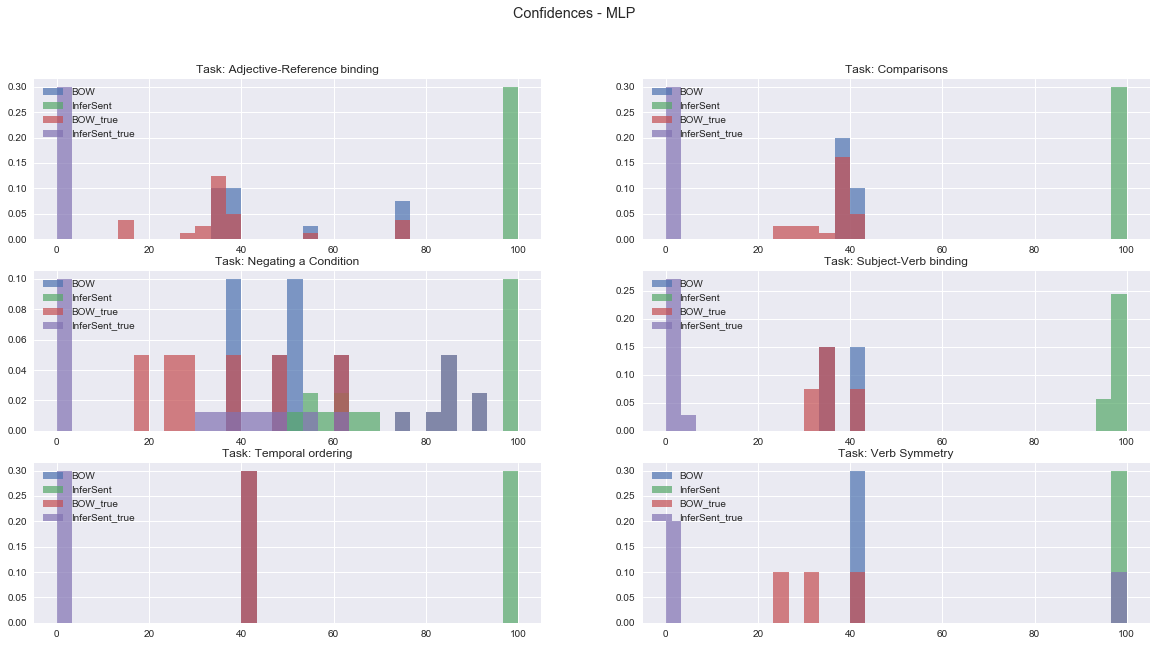

In [61]:
plt.figure(figsize=(20, 10))
n_task = 0

for task in tasks:
    n_task +=1 
    
    tru = np.array(all_results['BOW'+classifier][task]['true'])
    est_B = np.array(all_results['BOW'+classifier][task]['est'])
    est_I = np.array(all_results['InferSent'+classifier][task]['est'])
    filt = np.logical_and(est_B != tru, est_I == tru)
    
    conf_B = np.array([100*all_results['BOW'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(est_B)])
    conf_I = np.array([100*all_results['InferSent'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(est_I)])
    conf_B_intrue = np.array([100*all_results['BOW'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    conf_I_intrue = np.array([100*all_results['InferSent'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    
    diff_con = conf_I - conf_B
    diff_con = conf_B
    order = np.argsort(-diff_con)
    
    disp = 0
    for disp_i in order:
        if disp < N:
            if filt[disp_i]:
                #print(sents_A[disp_i])
                #print(sents_B[disp_i])
                #print("True: ", tru[disp_i], "\t Estimated BOW: ", est_B[disp_i])
                #print("IS conf: ", conf_I[disp_i], "\t BOW conf: ", conf_B[disp_i], "\t BOW conf in true: ", conf_B_intrue[disp_i])
                #print("\n", "*"*40, "\n")

                disp += 1
    plt.subplot(3,2, n_task)
    plt.hist(conf_B, range = (0,100), normed = True, bins = 30, label = 'BOW', alpha = 0.7)
    plt.hist(conf_I, range = (0,100), normed = True, bins = 30, label = 'InferSent', alpha = 0.7)
    plt.hist(conf_B_intrue, range = (0,100), normed = True, bins = 30, label = 'BOW_true', alpha = 0.7)
    plt.hist(conf_I_intrue, range = (0,100), normed = True, bins = 30, label = 'InferSent_true', alpha = 0.7)
    
    plt.legend(loc='upper left')
    plt.title('Task: {0}'.format(map_name[task]))
    

plt.suptitle('Confidences - MLP')        
plt.show()   
